In [1]:
import numpy as np 
import pandas as pd 

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/leukemia-classification/C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data_labels.csv
/kaggle/input/leukemia-classification/C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data/518.bmp
/kaggle/input/leukemia-classification/C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data/1307.bmp
/kaggle/input/leukemia-classification/C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data/1048.bmp
/kaggle/input/leukemia-classification/C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data/1399.bmp
/kaggle/input/leukemia-classification/C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data/1661.bmp
/kaggle/input/leukemia-classification/C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data/1577.bmp
/kaggle/input/leukemia-classification/C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data/665.bmp
/kaggle/input/leukemia-classification/C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data/1212.bmp
/kaggle/input/leukemia-classification

In [2]:
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, ConcatDataset
import torchvision.models as models
import torch.nn as nn

from collections import Counter
import random
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import tqdm

In [3]:
transform = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  
])

fold_0_dir = '/kaggle/input/leukemia-classification/C-NMC_Leukemia/training_data/fold_0'
fold_1_dir = '/kaggle/input/leukemia-classification/C-NMC_Leukemia/training_data/fold_1'
fold_2_dir = '/kaggle/input/leukemia-classification/C-NMC_Leukemia/training_data/fold_2'

fold_0_dataset = datasets.ImageFolder(root=fold_0_dir, transform=transform)
fold_1_dataset = datasets.ImageFolder(root=fold_1_dir, transform=transform)
fold_2_dataset = datasets.ImageFolder(root=fold_2_dir, transform=transform)

full_dataset = ConcatDataset([fold_0_dataset, fold_1_dataset, fold_2_dataset])

In [4]:
class_names = fold_0_dataset.classes 
class_indices = {class_name: [] for class_name in class_names}

for idx, (_, label) in enumerate(full_dataset):
    class_name = class_names[label]
    class_indices[class_name].append(idx)

In [5]:
def limit_dataset(dataset, max_train_samples=None, max_test_samples=None):
    train_indices = []
    if max_train_samples:
        for class_name, max_samples in max_train_samples.items():
            indices = class_indices[class_name]
            max_samples_per_class = min(max_samples, len(indices))
            selected_indices = random.sample(indices, max_samples_per_class)
            train_indices.extend(selected_indices)
  
    for indices in train_indices:
        class_name = class_names[dataset[indices][1]]
        class_indices[class_name].remove(indices)
    
    test_indices = []
    if max_test_samples:
        all_test_indices = list(range(len(dataset)))
        test_indices = random.sample(all_test_indices, min(max_test_samples, len(all_test_indices)))
    return train_indices, test_indices

max_train_samples = {'all': 7000, 'hem': 3000}  
max_test_samples = 2000  
train_indices, test_indices = limit_dataset(full_dataset, max_train_samples=max_train_samples, max_test_samples=max_test_samples)

train_dataset = torch.utils.data.Subset(full_dataset, train_indices)
test_dataset = torch.utils.data.Subset(full_dataset, test_indices)

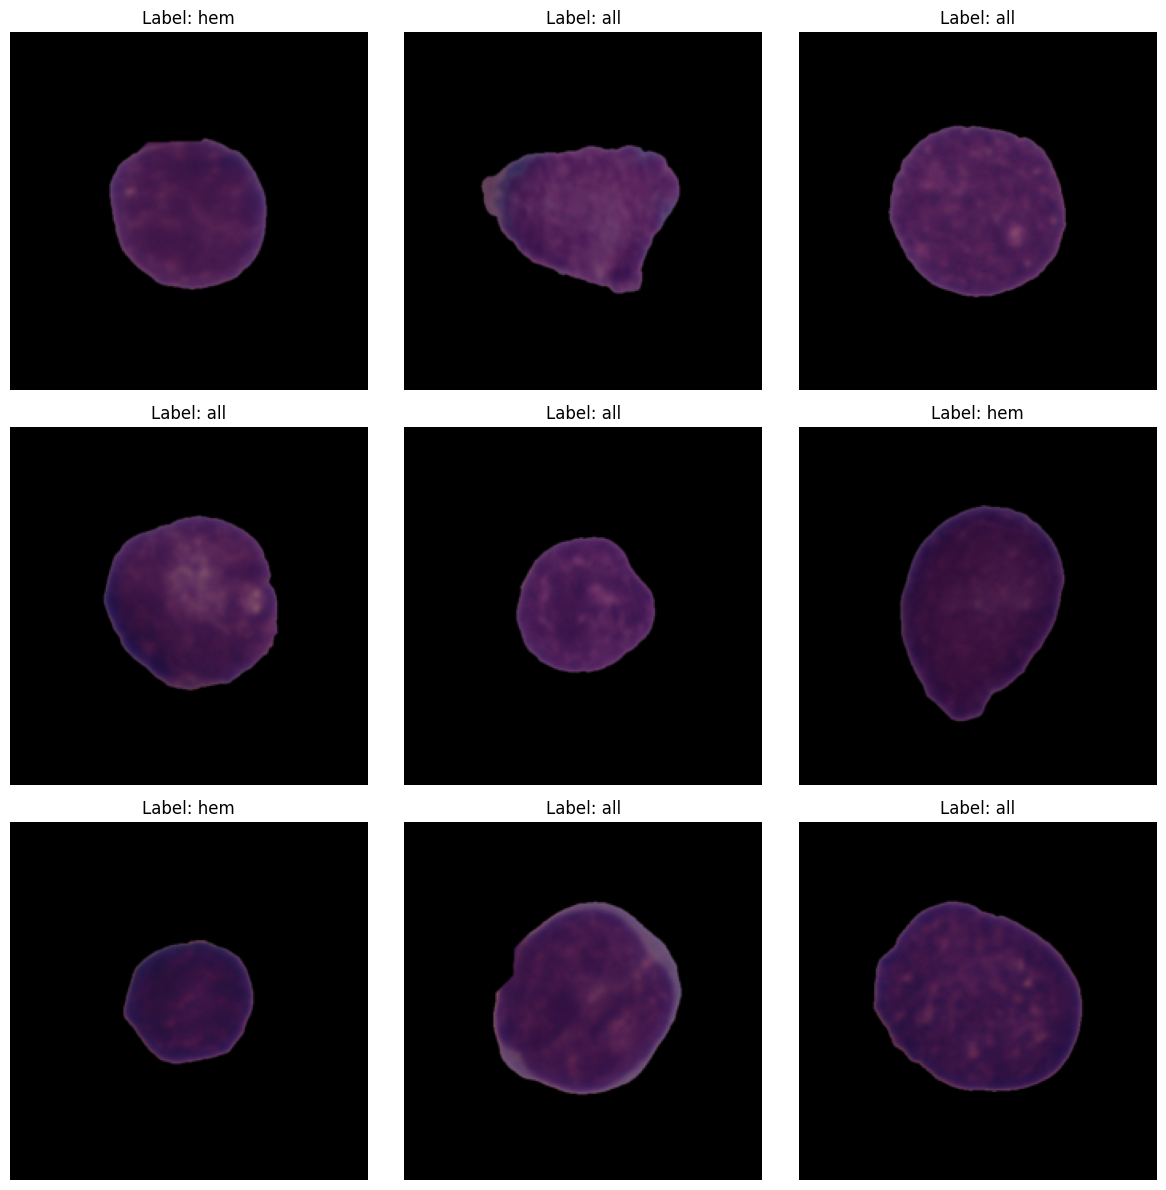

In [16]:
import matplotlib.pyplot as plt

def show_images(dataset, num_images=9):
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))
    axes = axes.flatten()
    
    for i in range(num_images):
        idx = random.randint(0, len(dataset) - 1)
        image, label = dataset[idx]
        image_np = image.permute(1, 2, 0).numpy()
        image_np = image_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        image_np = np.clip(image_np, 0, 1)
        axes[i].imshow(image_np)
        axes[i].set_title(f"Label: {class_names[label]}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

show_images(train_dataset, num_images=9)

Number of data points in train loader: 10000
Number of data points in test loader: 2000


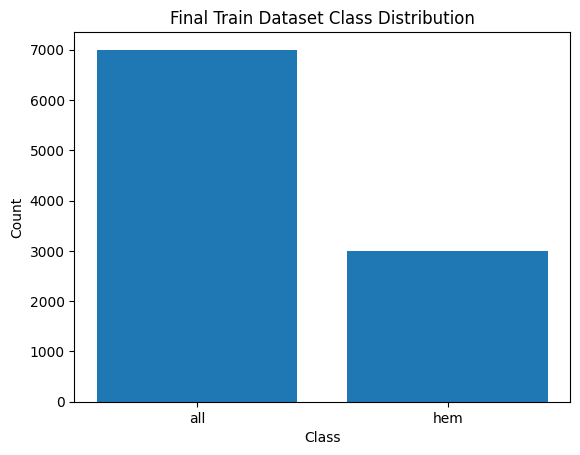

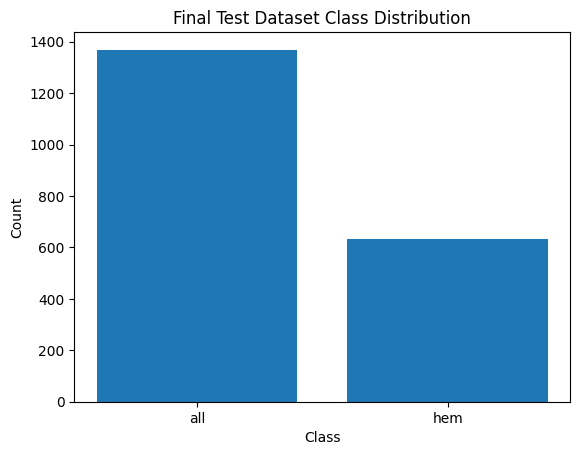

In [6]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

print(f"Number of data points in train loader: {len(train_dataset)}")
print(f"Number of data points in test loader: {len(test_dataset)}")

def get_class_distribution(dataset):
    class_counts = Counter()
    for _, label in dataset:
        class_counts[label] += 1
    return class_counts

train_class_distribution = get_class_distribution(train_dataset)
test_class_distribution = get_class_distribution(test_dataset)

def plot_class_distribution(class_distribution, title):
    classes = list(class_distribution.keys())
    counts = list(class_distribution.values())

    plt.bar(classes, counts)
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.title(title)
    plt.xticks(classes, [class_names[i] for i in classes])
    plt.show()

plot_class_distribution(train_class_distribution, "Final Train Dataset Class Distribution")
plot_class_distribution(test_class_distribution, "Final Test Dataset Class Distribution")

In [7]:
model = models.resnet18(pretrained=True)

num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    torch.nn.Linear(num_ftrs, 4),
    torch.nn.Linear(4, 2),
)
model

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 189MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [8]:
Freeze = False
if Freeze:
    for param in model.parameters():
        param.requires_grad = False

    for param in model.fc.parameters():
        param.requires_grad = True

In [9]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_losses = []
val_losses = []
train_accs = []
val_accs = []

In [10]:
device

device(type='cuda')

In [11]:
num_epochs = 64
best_loss = 1000

for epoch in range(num_epochs):
    model.to(device) 
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in tqdm.tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Training)", unit="batch"):
        inputs, labels = inputs.to(device), labels.to(device) 
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    train_acc = 100 * correct / total
    train_accs.append(train_acc)
    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss}, Training Accuracy: {train_acc}%')

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in tqdm.tqdm(test_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Validation)", unit="batch"):
            inputs, labels = inputs.to(device), labels.to(device)  # Move the data to the device
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_loss /= len(test_loader)
    val_losses.append(val_loss)
    val_acc = 100 * correct / total
    val_accs.append(val_acc)
    
    if val_loss < best_loss:
        print("Saving model...")
        torch.save(model.state_dict(), 'model.pth')
        best_loss = val_loss

    print(f'Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss}, Validation Accuracy: {val_acc}%')
torch.save(model.state_dict(), 'model_last.pth')

Epoch 1/64 (Training): 100%|██████████| 313/313 [00:22<00:00, 13.90batch/s]


Epoch 1/64, Training Loss: 0.29991654761302206, Training Accuracy: 87.72%


Epoch 1/64 (Validation): 100%|██████████| 63/63 [00:03<00:00, 17.51batch/s]


Saving model...
Epoch 1/64, Validation Loss: 0.23170358273718092, Validation Accuracy: 90.45%


Epoch 2/64 (Training): 100%|██████████| 313/313 [00:21<00:00, 14.84batch/s]


Epoch 2/64, Training Loss: 0.18989121986511417, Training Accuracy: 92.81%


Epoch 2/64 (Validation): 100%|██████████| 63/63 [00:05<00:00, 12.17batch/s]


Saving model...
Epoch 2/64, Validation Loss: 0.1237823578809935, Validation Accuracy: 95.55%


Epoch 3/64 (Training): 100%|██████████| 313/313 [00:21<00:00, 14.81batch/s]


Epoch 3/64, Training Loss: 0.13127940234403832, Training Accuracy: 94.96%


Epoch 3/64 (Validation): 100%|██████████| 63/63 [00:03<00:00, 16.65batch/s]


Epoch 3/64, Validation Loss: 0.24213120512782582, Validation Accuracy: 89.3%


Epoch 4/64 (Training): 100%|██████████| 313/313 [00:21<00:00, 14.61batch/s]


Epoch 4/64, Training Loss: 0.09944257490075054, Training Accuracy: 96.15%


Epoch 4/64 (Validation): 100%|██████████| 63/63 [00:03<00:00, 17.07batch/s]


Saving model...
Epoch 4/64, Validation Loss: 0.053128382856292386, Validation Accuracy: 98.75%


Epoch 5/64 (Training): 100%|██████████| 313/313 [00:21<00:00, 14.55batch/s]


Epoch 5/64, Training Loss: 0.062363323604557125, Training Accuracy: 97.78%


Epoch 5/64 (Validation): 100%|██████████| 63/63 [00:03<00:00, 16.99batch/s]


Epoch 5/64, Validation Loss: 0.17300892953524397, Validation Accuracy: 93.85%


Epoch 6/64 (Training): 100%|██████████| 313/313 [00:21<00:00, 14.34batch/s]


Epoch 6/64, Training Loss: 0.04149348117257156, Training Accuracy: 98.44%


Epoch 6/64 (Validation): 100%|██████████| 63/63 [00:03<00:00, 17.31batch/s]


Saving model...
Epoch 6/64, Validation Loss: 0.04237730339509509, Validation Accuracy: 98.65%


Epoch 7/64 (Training): 100%|██████████| 313/313 [00:21<00:00, 14.61batch/s]


Epoch 7/64, Training Loss: 0.042717983168397346, Training Accuracy: 98.44%


Epoch 7/64 (Validation): 100%|██████████| 63/63 [00:04<00:00, 15.27batch/s]


Epoch 7/64, Validation Loss: 0.08123582745541907, Validation Accuracy: 96.65%


Epoch 8/64 (Training): 100%|██████████| 313/313 [00:21<00:00, 14.64batch/s]


Epoch 8/64, Training Loss: 0.02965048230558146, Training Accuracy: 98.86%


Epoch 8/64 (Validation): 100%|██████████| 63/63 [00:03<00:00, 17.73batch/s]


Saving model...
Epoch 8/64, Validation Loss: 0.03343237818880302, Validation Accuracy: 99.0%


Epoch 9/64 (Training): 100%|██████████| 313/313 [00:21<00:00, 14.59batch/s]


Epoch 9/64, Training Loss: 0.02554773906812655, Training Accuracy: 99.06%


Epoch 9/64 (Validation): 100%|██████████| 63/63 [00:03<00:00, 16.99batch/s]


Epoch 9/64, Validation Loss: 0.04855493721847851, Validation Accuracy: 98.4%


Epoch 10/64 (Training): 100%|██████████| 313/313 [00:21<00:00, 14.58batch/s]


Epoch 10/64, Training Loss: 0.032038515061549186, Training Accuracy: 98.8%


Epoch 10/64 (Validation): 100%|██████████| 63/63 [00:03<00:00, 17.28batch/s]


Epoch 10/64, Validation Loss: 0.07060839391926983, Validation Accuracy: 97.25%


Epoch 11/64 (Training): 100%|██████████| 313/313 [00:21<00:00, 14.63batch/s]


Epoch 11/64, Training Loss: 0.02375327136398058, Training Accuracy: 99.22%


Epoch 11/64 (Validation): 100%|██████████| 63/63 [00:03<00:00, 16.62batch/s]


Epoch 11/64, Validation Loss: 0.042438875575224674, Validation Accuracy: 98.8%


Epoch 12/64 (Training): 100%|██████████| 313/313 [00:21<00:00, 14.75batch/s]


Epoch 12/64, Training Loss: 0.03195297856440064, Training Accuracy: 98.94%


Epoch 12/64 (Validation): 100%|██████████| 63/63 [00:03<00:00, 17.11batch/s]


Epoch 12/64, Validation Loss: 0.03924381346829856, Validation Accuracy: 98.9%


Epoch 13/64 (Training): 100%|██████████| 313/313 [00:21<00:00, 14.52batch/s]


Epoch 13/64, Training Loss: 0.006922453535983291, Training Accuracy: 99.81%


Epoch 13/64 (Validation): 100%|██████████| 63/63 [00:03<00:00, 17.01batch/s]


Saving model...
Epoch 13/64, Validation Loss: 0.01650529327023486, Validation Accuracy: 99.65%


Epoch 14/64 (Training): 100%|██████████| 313/313 [00:21<00:00, 14.46batch/s]


Epoch 14/64, Training Loss: 0.01137482557366868, Training Accuracy: 99.61%


Epoch 14/64 (Validation): 100%|██████████| 63/63 [00:03<00:00, 16.35batch/s]


Epoch 14/64, Validation Loss: 0.029718798245691385, Validation Accuracy: 99.2%


Epoch 15/64 (Training): 100%|██████████| 313/313 [00:21<00:00, 14.43batch/s]


Epoch 15/64, Training Loss: 0.03023951573348708, Training Accuracy: 99.11%


Epoch 15/64 (Validation): 100%|██████████| 63/63 [00:03<00:00, 17.32batch/s]


Epoch 15/64, Validation Loss: 0.6262421961578112, Validation Accuracy: 81.25%


Epoch 16/64 (Training): 100%|██████████| 313/313 [00:21<00:00, 14.75batch/s]


Epoch 16/64, Training Loss: 0.021962182251543116, Training Accuracy: 99.32%


Epoch 16/64 (Validation): 100%|██████████| 63/63 [00:04<00:00, 15.39batch/s]


Epoch 16/64, Validation Loss: 0.026494553045296694, Validation Accuracy: 99.5%


Epoch 17/64 (Training): 100%|██████████| 313/313 [00:21<00:00, 14.64batch/s]


Epoch 17/64, Training Loss: 0.006936915049077136, Training Accuracy: 99.77%


Epoch 17/64 (Validation): 100%|██████████| 63/63 [00:03<00:00, 17.14batch/s]


Epoch 17/64, Validation Loss: 0.023335109421745912, Validation Accuracy: 99.5%


Epoch 18/64 (Training): 100%|██████████| 313/313 [00:21<00:00, 14.45batch/s]


Epoch 18/64, Training Loss: 0.0020633338160598344, Training Accuracy: 99.98%


Epoch 18/64 (Validation): 100%|██████████| 63/63 [00:03<00:00, 17.23batch/s]


Epoch 18/64, Validation Loss: 0.026599976311921465, Validation Accuracy: 99.6%


Epoch 19/64 (Training): 100%|██████████| 313/313 [00:21<00:00, 14.49batch/s]


Epoch 19/64, Training Loss: 0.022618113128376714, Training Accuracy: 99.29%


Epoch 19/64 (Validation): 100%|██████████| 63/63 [00:03<00:00, 16.63batch/s]


Epoch 19/64, Validation Loss: 0.0688342210977146, Validation Accuracy: 97.4%


Epoch 20/64 (Training): 100%|██████████| 313/313 [00:21<00:00, 14.67batch/s]


Epoch 20/64, Training Loss: 0.023733730386659397, Training Accuracy: 99.25%


Epoch 20/64 (Validation): 100%|██████████| 63/63 [00:03<00:00, 17.66batch/s]


Epoch 20/64, Validation Loss: 0.024022686276732694, Validation Accuracy: 99.2%


Epoch 21/64 (Training): 100%|██████████| 313/313 [00:21<00:00, 14.79batch/s]


Epoch 21/64, Training Loss: 0.009639001432533812, Training Accuracy: 99.67%


Epoch 21/64 (Validation): 100%|██████████| 63/63 [00:04<00:00, 15.66batch/s]


Epoch 21/64, Validation Loss: 0.023584747485825026, Validation Accuracy: 99.55%


Epoch 22/64 (Training): 100%|██████████| 313/313 [00:21<00:00, 14.77batch/s]


Epoch 22/64, Training Loss: 0.007631914975927459, Training Accuracy: 99.75%


Epoch 22/64 (Validation): 100%|██████████| 63/63 [00:03<00:00, 17.34batch/s]


Epoch 22/64, Validation Loss: 0.7145029774733952, Validation Accuracy: 79.95%


Epoch 23/64 (Training): 100%|██████████| 313/313 [00:21<00:00, 14.59batch/s]


Epoch 23/64, Training Loss: 0.02330625010380029, Training Accuracy: 99.15%


Epoch 23/64 (Validation): 100%|██████████| 63/63 [00:03<00:00, 17.23batch/s]


Epoch 23/64, Validation Loss: 0.026464966131791858, Validation Accuracy: 99.4%


Epoch 24/64 (Training): 100%|██████████| 313/313 [00:21<00:00, 14.46batch/s]


Epoch 24/64, Training Loss: 0.013337267458303303, Training Accuracy: 99.45%


Epoch 24/64 (Validation): 100%|██████████| 63/63 [00:03<00:00, 17.46batch/s]


Epoch 24/64, Validation Loss: 0.03546859601403181, Validation Accuracy: 99.1%


Epoch 25/64 (Training): 100%|██████████| 313/313 [00:21<00:00, 14.68batch/s]


Epoch 25/64, Training Loss: 0.002983553603862616, Training Accuracy: 99.89%


Epoch 25/64 (Validation): 100%|██████████| 63/63 [00:03<00:00, 17.61batch/s]


Epoch 25/64, Validation Loss: 0.023939082480684725, Validation Accuracy: 99.45%


Epoch 26/64 (Training): 100%|██████████| 313/313 [00:21<00:00, 14.67batch/s]


Epoch 26/64, Training Loss: 0.023052956654268222, Training Accuracy: 99.25%


Epoch 26/64 (Validation): 100%|██████████| 63/63 [00:03<00:00, 17.16batch/s]


Epoch 26/64, Validation Loss: 0.029959546567018453, Validation Accuracy: 99.4%


Epoch 27/64 (Training): 100%|██████████| 313/313 [00:21<00:00, 14.69batch/s]


Epoch 27/64, Training Loss: 0.007553315847398365, Training Accuracy: 99.72%


Epoch 27/64 (Validation): 100%|██████████| 63/63 [00:03<00:00, 16.59batch/s]


Epoch 27/64, Validation Loss: 0.030626936094088866, Validation Accuracy: 99.2%


Epoch 28/64 (Training): 100%|██████████| 313/313 [00:21<00:00, 14.61batch/s]


Epoch 28/64, Training Loss: 0.0024764444998536333, Training Accuracy: 99.92%


Epoch 28/64 (Validation): 100%|██████████| 63/63 [00:04<00:00, 13.78batch/s]


Epoch 28/64, Validation Loss: 0.02888310440361209, Validation Accuracy: 99.4%


Epoch 29/64 (Training): 100%|██████████| 313/313 [00:21<00:00, 14.27batch/s]


Epoch 29/64, Training Loss: 0.00841604115034694, Training Accuracy: 99.76%


Epoch 29/64 (Validation): 100%|██████████| 63/63 [00:03<00:00, 17.70batch/s]


Epoch 29/64, Validation Loss: 0.17695211489880752, Validation Accuracy: 94.9%


Epoch 30/64 (Training): 100%|██████████| 313/313 [00:21<00:00, 14.81batch/s]


Epoch 30/64, Training Loss: 0.019290134333061634, Training Accuracy: 99.33%


Epoch 30/64 (Validation): 100%|██████████| 63/63 [00:03<00:00, 15.75batch/s]


Epoch 30/64, Validation Loss: 0.027069568703414655, Validation Accuracy: 99.4%


Epoch 31/64 (Training): 100%|██████████| 313/313 [00:21<00:00, 14.82batch/s]


Epoch 31/64, Training Loss: 0.0031734725033909406, Training Accuracy: 99.9%


Epoch 31/64 (Validation): 100%|██████████| 63/63 [00:03<00:00, 16.97batch/s]


Epoch 31/64, Validation Loss: 0.23371434230948723, Validation Accuracy: 93.9%


Epoch 32/64 (Training): 100%|██████████| 313/313 [00:21<00:00, 14.44batch/s]


Epoch 32/64, Training Loss: 0.010803734240987444, Training Accuracy: 99.67%


Epoch 32/64 (Validation): 100%|██████████| 63/63 [00:03<00:00, 17.60batch/s]


Epoch 32/64, Validation Loss: 0.03439484684892546, Validation Accuracy: 99.2%


Epoch 33/64 (Training): 100%|██████████| 313/313 [00:21<00:00, 14.68batch/s]


Epoch 33/64, Training Loss: 0.006428069278612407, Training Accuracy: 99.75%


Epoch 33/64 (Validation): 100%|██████████| 63/63 [00:03<00:00, 16.98batch/s]


Epoch 33/64, Validation Loss: 0.05071575284059763, Validation Accuracy: 98.8%


Epoch 34/64 (Training): 100%|██████████| 313/313 [00:21<00:00, 14.59batch/s]


Epoch 34/64, Training Loss: 0.008688760041328502, Training Accuracy: 99.7%


Epoch 34/64 (Validation): 100%|██████████| 63/63 [00:03<00:00, 17.10batch/s]


Epoch 34/64, Validation Loss: 0.041357999784056104, Validation Accuracy: 99.35%


Epoch 35/64 (Training): 100%|██████████| 313/313 [00:21<00:00, 14.82batch/s]


Epoch 35/64, Training Loss: 0.0069276554652950755, Training Accuracy: 99.78%


Epoch 35/64 (Validation): 100%|██████████| 63/63 [00:03<00:00, 16.19batch/s]


Epoch 35/64, Validation Loss: 0.04055949038253843, Validation Accuracy: 99.4%


Epoch 36/64 (Training): 100%|██████████| 313/313 [00:21<00:00, 14.71batch/s]


Epoch 36/64, Training Loss: 0.012108131866329242, Training Accuracy: 99.58%


Epoch 36/64 (Validation): 100%|██████████| 63/63 [00:03<00:00, 17.21batch/s]


Epoch 36/64, Validation Loss: 0.11926032161933281, Validation Accuracy: 97.25%


Epoch 37/64 (Training): 100%|██████████| 313/313 [00:21<00:00, 14.60batch/s]


Epoch 37/64, Training Loss: 0.012916581359099009, Training Accuracy: 99.57%


Epoch 37/64 (Validation): 100%|██████████| 63/63 [00:03<00:00, 17.70batch/s]


Epoch 37/64, Validation Loss: 0.028128415599966834, Validation Accuracy: 99.5%


Epoch 38/64 (Training): 100%|██████████| 313/313 [00:21<00:00, 14.49batch/s]


Epoch 38/64, Training Loss: 0.002430441672476417, Training Accuracy: 99.93%


Epoch 38/64 (Validation): 100%|██████████| 63/63 [00:03<00:00, 17.03batch/s]


Epoch 38/64, Validation Loss: 0.024735591238721908, Validation Accuracy: 99.6%


Epoch 39/64 (Training): 100%|██████████| 313/313 [00:21<00:00, 14.58batch/s]


Epoch 39/64, Training Loss: 0.0007499874417380822, Training Accuracy: 99.98%


Epoch 39/64 (Validation): 100%|██████████| 63/63 [00:03<00:00, 17.38batch/s]


Epoch 39/64, Validation Loss: 0.02614835218544555, Validation Accuracy: 99.45%


Epoch 40/64 (Training): 100%|██████████| 313/313 [00:21<00:00, 14.75batch/s]


Epoch 40/64, Training Loss: 0.01633483810352167, Training Accuracy: 99.52%


Epoch 40/64 (Validation): 100%|██████████| 63/63 [00:03<00:00, 16.69batch/s]


Epoch 40/64, Validation Loss: 0.2590108648060806, Validation Accuracy: 93.55%


Epoch 41/64 (Training): 100%|██████████| 313/313 [00:21<00:00, 14.66batch/s]


Epoch 41/64, Training Loss: 0.010374218075203287, Training Accuracy: 99.64%


Epoch 41/64 (Validation): 100%|██████████| 63/63 [00:03<00:00, 17.39batch/s]


Epoch 41/64, Validation Loss: 0.061283943954982704, Validation Accuracy: 98.75%


Epoch 42/64 (Training): 100%|██████████| 313/313 [00:21<00:00, 14.60batch/s]


Epoch 42/64, Training Loss: 0.009521144705101329, Training Accuracy: 99.73%


Epoch 42/64 (Validation): 100%|██████████| 63/63 [00:03<00:00, 17.03batch/s]


Epoch 42/64, Validation Loss: 2.06841487969671, Validation Accuracy: 76.55%


Epoch 43/64 (Training): 100%|██████████| 313/313 [00:21<00:00, 14.56batch/s]


Epoch 43/64, Training Loss: 0.012107406281986546, Training Accuracy: 99.59%


Epoch 43/64 (Validation): 100%|██████████| 63/63 [00:03<00:00, 17.41batch/s]


Epoch 43/64, Validation Loss: 0.02776033798637934, Validation Accuracy: 99.45%


Epoch 44/64 (Training): 100%|██████████| 313/313 [00:21<00:00, 14.86batch/s]


Epoch 44/64, Training Loss: 0.002361851034162266, Training Accuracy: 99.94%


Epoch 44/64 (Validation): 100%|██████████| 63/63 [00:04<00:00, 15.31batch/s]


Epoch 44/64, Validation Loss: 0.023072131589737227, Validation Accuracy: 99.55%


Epoch 45/64 (Training): 100%|██████████| 313/313 [00:21<00:00, 14.87batch/s]


Epoch 45/64, Training Loss: 0.000182124658778729, Training Accuracy: 100.0%


Epoch 45/64 (Validation): 100%|██████████| 63/63 [00:03<00:00, 17.22batch/s]


Epoch 45/64, Validation Loss: 0.024863395316562974, Validation Accuracy: 99.5%


Epoch 46/64 (Training): 100%|██████████| 313/313 [00:21<00:00, 14.55batch/s]


Epoch 46/64, Training Loss: 0.00011734186673870987, Training Accuracy: 100.0%


Epoch 46/64 (Validation): 100%|██████████| 63/63 [00:03<00:00, 16.71batch/s]


Epoch 46/64, Validation Loss: 0.024754128455085612, Validation Accuracy: 99.55%


Epoch 47/64 (Training): 100%|██████████| 313/313 [00:21<00:00, 14.30batch/s]


Epoch 47/64, Training Loss: 0.00015838282102906463, Training Accuracy: 100.0%


Epoch 47/64 (Validation): 100%|██████████| 63/63 [00:03<00:00, 16.76batch/s]


Epoch 47/64, Validation Loss: 0.02780166817599627, Validation Accuracy: 99.5%


Epoch 48/64 (Training): 100%|██████████| 313/313 [00:21<00:00, 14.48batch/s]


Epoch 48/64, Training Loss: 8.311584442704777e-05, Training Accuracy: 100.0%


Epoch 48/64 (Validation): 100%|██████████| 63/63 [00:03<00:00, 17.42batch/s]


Epoch 48/64, Validation Loss: 0.02817081469773695, Validation Accuracy: 99.55%


Epoch 49/64 (Training): 100%|██████████| 313/313 [00:21<00:00, 14.81batch/s]


Epoch 49/64, Training Loss: 5.771950715082409e-05, Training Accuracy: 100.0%


Epoch 49/64 (Validation): 100%|██████████| 63/63 [00:03<00:00, 16.52batch/s]


Epoch 49/64, Validation Loss: 0.030325863671358456, Validation Accuracy: 99.55%


Epoch 50/64 (Training): 100%|██████████| 313/313 [00:21<00:00, 14.62batch/s]


Epoch 50/64, Training Loss: 2.8673766991640953e-05, Training Accuracy: 100.0%


Epoch 50/64 (Validation): 100%|██████████| 63/63 [00:03<00:00, 17.00batch/s]


Epoch 50/64, Validation Loss: 0.030448152007301284, Validation Accuracy: 99.5%


Epoch 51/64 (Training): 100%|██████████| 313/313 [00:21<00:00, 14.40batch/s]


Epoch 51/64, Training Loss: 2.650943703141008e-05, Training Accuracy: 100.0%


Epoch 51/64 (Validation): 100%|██████████| 63/63 [00:03<00:00, 17.67batch/s]


Epoch 51/64, Validation Loss: 0.030379072064595128, Validation Accuracy: 99.6%


Epoch 52/64 (Training): 100%|██████████| 313/313 [00:21<00:00, 14.66batch/s]


Epoch 52/64, Training Loss: 0.049136610059110554, Training Accuracy: 98.38%


Epoch 52/64 (Validation): 100%|██████████| 63/63 [00:03<00:00, 17.45batch/s]


Epoch 52/64, Validation Loss: 0.1750034676598651, Validation Accuracy: 94.95%


Epoch 53/64 (Training): 100%|██████████| 313/313 [00:21<00:00, 14.78batch/s]


Epoch 53/64, Training Loss: 0.010138944437810646, Training Accuracy: 99.66%


Epoch 53/64 (Validation): 100%|██████████| 63/63 [00:03<00:00, 16.51batch/s]


Epoch 53/64, Validation Loss: 0.024627050157866346, Validation Accuracy: 99.65%


Epoch 54/64 (Training): 100%|██████████| 313/313 [00:21<00:00, 14.46batch/s]


Epoch 54/64, Training Loss: 0.005907362140155478, Training Accuracy: 99.83%


Epoch 54/64 (Validation): 100%|██████████| 63/63 [00:03<00:00, 17.81batch/s]


Epoch 54/64, Validation Loss: 0.0443304493152056, Validation Accuracy: 98.85%


Epoch 55/64 (Training): 100%|██████████| 313/313 [00:21<00:00, 14.58batch/s]


Epoch 55/64, Training Loss: 0.009450225746347544, Training Accuracy: 99.75%


Epoch 55/64 (Validation): 100%|██████████| 63/63 [00:03<00:00, 17.27batch/s]


Epoch 55/64, Validation Loss: 0.02809672635332448, Validation Accuracy: 99.4%


Epoch 56/64 (Training): 100%|██████████| 313/313 [00:21<00:00, 14.61batch/s]


Epoch 56/64, Training Loss: 0.0016574441757684006, Training Accuracy: 99.94%


Epoch 56/64 (Validation): 100%|██████████| 63/63 [00:03<00:00, 17.37batch/s]


Epoch 56/64, Validation Loss: 0.01699275051225327, Validation Accuracy: 99.6%


Epoch 57/64 (Training): 100%|██████████| 313/313 [00:21<00:00, 14.69batch/s]


Epoch 57/64, Training Loss: 0.006219630278574535, Training Accuracy: 99.83%


Epoch 57/64 (Validation): 100%|██████████| 63/63 [00:03<00:00, 17.29batch/s]


Epoch 57/64, Validation Loss: 0.025090745079458947, Validation Accuracy: 99.4%


Epoch 58/64 (Training): 100%|██████████| 313/313 [00:21<00:00, 14.85batch/s]


Epoch 58/64, Training Loss: 0.0007742032810143608, Training Accuracy: 99.98%


Epoch 58/64 (Validation): 100%|██████████| 63/63 [00:04<00:00, 15.41batch/s]


Epoch 58/64, Validation Loss: 0.03467881898310254, Validation Accuracy: 99.4%


Epoch 59/64 (Training): 100%|██████████| 313/313 [00:21<00:00, 14.73batch/s]


Epoch 59/64, Training Loss: 0.011311445447452675, Training Accuracy: 99.64%


Epoch 59/64 (Validation): 100%|██████████| 63/63 [00:03<00:00, 17.39batch/s]


Epoch 59/64, Validation Loss: 0.030376184371850704, Validation Accuracy: 99.3%


Epoch 60/64 (Training): 100%|██████████| 313/313 [00:21<00:00, 14.66batch/s]


Epoch 60/64, Training Loss: 0.009536130612488454, Training Accuracy: 99.65%


Epoch 60/64 (Validation): 100%|██████████| 63/63 [00:03<00:00, 17.68batch/s]


Epoch 60/64, Validation Loss: 0.05681659119681359, Validation Accuracy: 98.4%


Epoch 61/64 (Training): 100%|██████████| 313/313 [00:21<00:00, 14.42batch/s]


Epoch 61/64, Training Loss: 0.013115650554062393, Training Accuracy: 99.54%


Epoch 61/64 (Validation): 100%|██████████| 63/63 [00:03<00:00, 16.91batch/s]


Epoch 61/64, Validation Loss: 0.03800009160765931, Validation Accuracy: 99.5%


Epoch 62/64 (Training): 100%|██████████| 313/313 [00:21<00:00, 14.68batch/s]


Epoch 62/64, Training Loss: 0.00065471038474519, Training Accuracy: 100.0%


Epoch 62/64 (Validation): 100%|██████████| 63/63 [00:03<00:00, 16.83batch/s]


Epoch 62/64, Validation Loss: 0.036215901828384064, Validation Accuracy: 99.4%


Epoch 63/64 (Training): 100%|██████████| 313/313 [00:21<00:00, 14.73batch/s]


Epoch 63/64, Training Loss: 0.00021343200339256197, Training Accuracy: 100.0%


Epoch 63/64 (Validation): 100%|██████████| 63/63 [00:03<00:00, 17.62batch/s]


Epoch 63/64, Validation Loss: 0.034709730132272666, Validation Accuracy: 99.4%


Epoch 64/64 (Training): 100%|██████████| 313/313 [00:21<00:00, 14.50batch/s]


Epoch 64/64, Training Loss: 0.00014583983970598678, Training Accuracy: 100.0%


Epoch 64/64 (Validation): 100%|██████████| 63/63 [00:03<00:00, 17.69batch/s]

Epoch 64/64, Validation Loss: 0.03980020402743307, Validation Accuracy: 99.35%


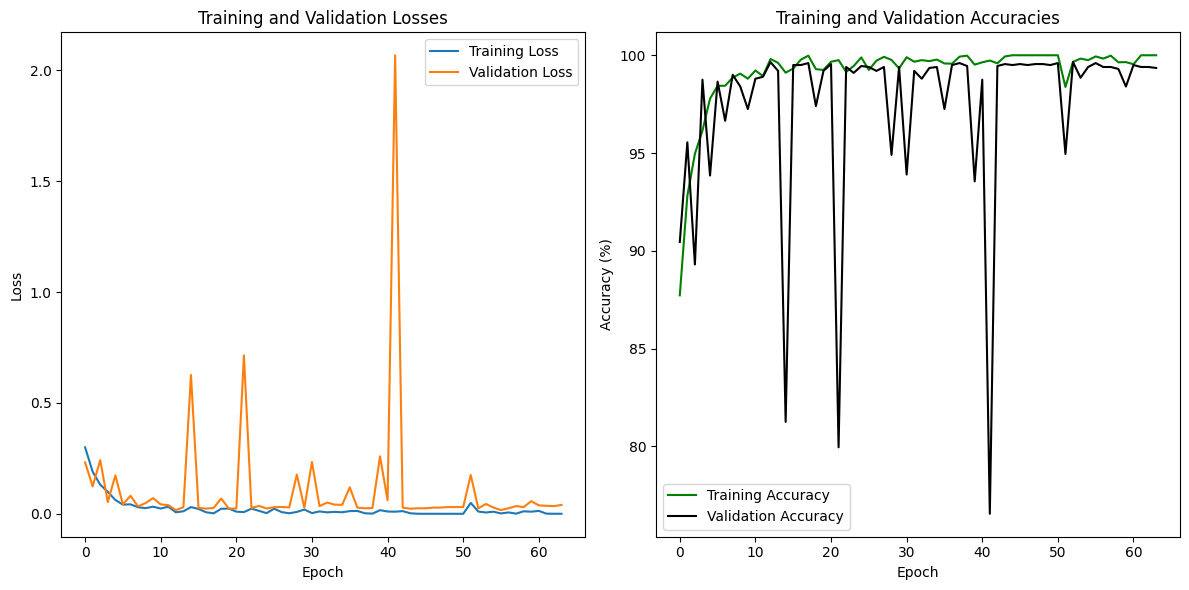

In [12]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Training Accuracy', color='green')
plt.plot(val_accs, label='Validation Accuracy', color='black')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracies')
plt.legend()

plt.tight_layout()
plt.show()

In [13]:
model_path = '/kaggle/working/model.pth'
model.load_state_dict(torch.load(model_path))

/tmp/ipykernel_30/1258757798.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


<All keys matched successfully>

In [15]:
import torch
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
import time

model.eval()

correct = 0
total = 0
all_labels = []
all_predictions = []

start_time = time.time()

with torch.no_grad():
    for inputs, labels in test_loader:  
        outputs = model(inputs.to(device))
        _, predicted = torch.max(outputs.data.to('cpu'), 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

end_time = time.time()
computational_time = end_time - start_time

accuracy = 100 * correct / total

all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

precision = precision_score(all_labels, all_predictions, average='weighted', zero_division=0)
recall = recall_score(all_labels, all_predictions, average='weighted', zero_division=0)
f1 = f1_score(all_labels, all_predictions, average='weighted', zero_division=0)
conf_matrix = confusion_matrix(all_labels, all_predictions)

print('Confusion Matrix:')
print(conf_matrix)

if conf_matrix.shape == (2, 2):
    tn, fp, fn, tp = conf_matrix.ravel()  
    sensitivity = tp / (tp + fn) 
    specificity = tn / (tn + fp)  
else:
    sensitivity = None
    specificity = None

error_rate = 1 - accuracy / 100

print(f'Accuracy: {accuracy}%')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
if sensitivity is not None and specificity is not None:
    print(f'Sensitivity: {sensitivity}')
    print(f'Specificity: {specificity}')
print(f'Error Rate: {error_rate}')
print(f'Computational Time: {computational_time:.2f} seconds')

Confusion Matrix:
[[1366    3]
 [   4  627]]
Accuracy: 99.65%
Precision: 0.9964990789016336
Recall: 0.9965
F1 Score: 0.9964992511318432
Sensitivity: 0.993660855784469
Specificity: 0.997808619430241
Error Rate: 0.0034999999999999476
Computational Time: 4.13 seconds


In [18]:
# 10661 images